In [1]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import glob
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import numpy as np
import os
import pandas as pd
import sunpy.coordinates.sun as sn
import scipy.ndimage as ndi
import scipy.stats as st
# Our own library for using spice with STEREO (https://github.com/LukeBarnard/stereo_spice)
from stereo_spice.coordinates import StereoSpice
# Local packages
import HUXt as H

spice = StereoSpice()


In [4]:
def setup_huxt(start_time, uniform_wind=True):
    """
    Initialise HUXt with some predetermined boundary/initial conditions
    start_time should be astropy.Time object.
    uniform_wind is flag for setting uniform 400km/s wind.
    """
    cr_num = np.fix(sn.carrington_rotation_number(start_time))
    ert = H.Observer('EARTH', start_time)

    # Set up HUXt for a 5 day simulation with homogenous inner boundary.
    vr_in, br_in = H.Hin.get_MAS_long_profile(cr_num, ert.lat.to(u.deg))
    if uniform_wind:
        vr_in = np.zeros(vr_in.shape) + 400*vr_in.unit
        
    model = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
                   br_boundary=br_in, lon_start=270*u.deg, lon_stop=90*u.deg, simtime=3.5*u.day, dt_scale=4)
    
    return model

def get_base_cme(v=1000, lon=0, lat=0, width=35, thickness=1):
    """
    Return the base CME, which is used to establish the pseudo-truth CME and the SIR ensemble
    """
    t_launch = (1*u.hr).to(u.s)
    cme = H.ConeCME(t_launch=t_launch, longitude=lon*u.deg, latitude=lat*u.deg, width=width*u.deg, v=v*(u.km/u.s), thickness=thickness*u.solRad)
    return cme

def perturb_cone_cme(cme):
    """
    Perturb a ConeCME's parameters. Used to establish the pseudo-truth CME and the initial SIR ensemble members. 
    """
    lon_spread = 10*u.deg
    lat_spread = 10*u.deg
    width_spread = 10*u.deg
    v_spread = 100*(u.km/u.s)
    thickness_spread = 1*u.solRad
    
    randoms = np.random.uniform(-1,1,5)
    lon_new = cme.longitude + randoms[0]*lon_spread
    lat_new = cme.latitude + randoms[1]*lat_spread
    width_new = cme.width + randoms[2]*width_spread
    v_new = cme.v + randoms[3]*v_spread
    thickness_new = cme.thickness + randoms[4]*thickness_spread
    
    cme_perturb = H.ConeCME(t_launch=cme.t_launch,
                            longitude=lon_new,
                            latitude=lat_new,
                            width=width_new,
                            v=v_new,
                            thickness=thickness_new)
    return cme_perturb

def compute_profile_difference(obs_flank, model_flank):
    """
    Compute the rms difference between the observed and modelled flank elongations. 
    """
    # Do interp rather than join of dataframes, as it generalises out of model world. 
    elon_interp = np.interp(obs_flank['time'].values, model_flank['time'].values, model_flank['el'].values, left=np.NaN, right=np.NaN)
    matched_model = pd.DataFrame({'time': obs_flank['time'].values, 'el': elon_interp})
    de = (matched_model['el'] - obs_flank['el'])**2
    n_rms_samp = np.sum(np.isfinite(de))
    rms = np.sqrt(de.mean(skipna=True))
    return rms, n_rms_samp

class Observer:
    
    @u.quantity_input(longitude=u.deg)
    def __init__(self, model, longitude, el_min=4.0, el_max=30.0):
        
        ert_ephem = model.get_observer('EARTH')
        
        self.time = ert_ephem.time 
        self.r = ert_ephem.r
        self.lon = ert_ephem.lon + longitude
        self.lat = ert_ephem.lat
        self.el_min = el_min
        self.el_max = el_max
        # Force longitude into 0-360 domain
        id_over = self.lon > 360*u.deg
        id_under = self.lon < 0*u.deg
        if np.any(id_over):
            self.lon[id_over] = self.lon[id_over] - 360*u.deg
        if np.any(id_under):
            self.lon[id_under] = self.lon[id_under] + 360*u.deg
        
        cme = model.cmes[0]
        self.model_flank = self.compute_flank_profile(cme)
        
    def compute_flank_profile(self, cme):
        """
        Compute the time elongation profile of the flank of a ConeCME in HUXt. The observer longtidue is specified relative to Earth,
        and but otherwise matches Earth's coords. 

        Parameters
        ----------
        observer_lon: Angular separation of Earth and the observer, in HEEQ.
        cme: A ConeCME object from a completed HUXt run (i.e the ConeCME.coords dictionary has been populated).
        Returns
        -------
        obs_profile: Pandas dataframe giving the coordinates of the ConeCME flank from STA's perspective, including the
                    time, elongation, position angle, and HEEQ radius and longitude.
        """
        times = Time([coord['time'] for i, coord in cme.coords.items()])

        # Compute observers location using earth ephem, adding on observers longitude offset from Earth and correct for runover 2*pi
        flank = pd.DataFrame(index=np.arange(times.size), columns=['time', 'el', 'r', 'lon'])
        flank['time'] = times.jd

        for i, coord in cme.coords.items():

            if len(coord['r']) == 0:
                flank.loc[i, ['lon','r', 'el']] = np.NaN
                continue

            r_obs = self.r[i]
            x_obs = self.r[i] * np.cos(self.lat[i]) * np.cos(self.lon[i])
            y_obs = self.r[i] * np.cos(self.lat[i]) * np.sin(self.lon[i])
            z_obs = self.r[i] * np.sin(self.lat[i])

            lon_cme = coord['lon']
            lat_cme = coord['lat']
            r_cme = coord['r']

            x_cme = r_cme * np.cos(lat_cme) * np.cos(lon_cme)
            y_cme = r_cme * np.cos(lat_cme) * np.sin(lon_cme)
            z_cme = r_cme * np.sin(lat_cme)
            #############
            # Compute the observer CME distance, S, and elongation

            x_cme_s = x_cme - x_obs
            y_cme_s = y_cme - y_obs
            z_cme_s = z_cme - z_obs
            s = np.sqrt(x_cme_s**2 + y_cme_s**2 + z_cme_s**2)

            numer = (r_obs**2 + s**2 - r_cme**2).value
            denom = (2.0 * r_obs * s).value
            e_obs = np.arccos(numer / denom)

            # Find the flank coordinate and update output
            id_obs_flank = np.argmax(e_obs)       
            flank.loc[i, 'lon'] = lon_cme[id_obs_flank].value
            flank.loc[i, 'r'] = r_cme[id_obs_flank].value
            flank.loc[i, 'el'] = np.rad2deg(e_obs[id_obs_flank])

        # Force values to be floats.
        keys = ['lon', 'r', 'el']
        flank[keys] = flank[keys].astype(np.float64)
        return flank
    
    def compute_synthetic_obs(self, el_spread=0.5, cadence=5, el_min=4.0, el_max=30.0):
        """
        Return synthetic observations with a specified uncertainty spread, cadence, and maximum elongation.
        el_spread = standard deviation of random gaussian noise added to the modelled elongation.
        cadence = The cadence with witch observations are returned, as a whole number of model time steps.
        el_min = The minimum elongation of the observers field of view.
        el_max = The maximum elongation of the observers field of view.
        """

        # Compute the time-elongation profiles of the CME flanks from STA and STB
        model_flank = self.model_flank.copy()

        # Remove invalid points
        model_flank.dropna(inplace=True)

        # Add observation noise.
        obs_flank = model_flank.loc[:, ['time', 'el']].copy()
        obs_flank['el'] = obs_flank['el'] + el_spread*np.random.randn(obs_flank.shape[0])

        # Only keep every dt_scale'th observation and reindex - dt_scale=5 corrsponds to ~2hr
        obs_flank = obs_flank[::cadence]
        obs_flank.set_index(np.arange(0, obs_flank.shape[0]), inplace=True)

        # Only return up to el_max ~ (approx HI1 FOV is 25deg)
        id_fov = (obs_flank['el'] >= el_min) & (obs_flank['el'] <= el_max)
        obs_flank = obs_flank[id_fov]
        return obs_flank

def get_cme_params(cme):
    """
    Form an array of the CME parameter values that are kept track of in the ensemble members.
    """
    params = np.array([cme.longitude.to('rad').value, cme.latitude.to('rad').value,
                       cme.width.to('rad').value, cme.thickness.to('km').value, cme.v.value])
    
    return params

def create_analysis_output_file(filename):
    """
    Create a HDF5 file for storing the SIR analysis steps.
    """
    proj_dirs = H._setup_dirs_()
    out_filepath = os.path.join(proj_dirs['out_data'], filename)
    if os.path.isfile(out_filepath):
        # File exists, so delete and start new.
        print("Warning: {} already exists. Overwriting".format(out_filepath))
        os.remove(out_filepath)

    out_file = h5py.File(out_filepath, 'w')
    return out_file

def plot_huxt_with_observer(time, model, observer, add_flank=False, add_fov=False):
    
    id_t = np.argmin(np.abs(model.time_out - time))

    # Get plotting data
    lon_arr, dlon, nlon = H.longitude_grid()
    lon, rad = np.meshgrid(lon_arr.value, model.r.value)
    mymap = mpl.cm.viridis
    v_sub = model.v_grid_cme.value[id_t, :, :].copy()
    # Insert into full array
    if lon_arr.size != model.lon.size:
        v = np.zeros((model.nr, nlon)) * np.NaN
        if model.lon.size != 1:
            for i, lo in enumerate(model.lon):
                id_match = np.argwhere(lon_arr == lo)[0][0]
                v[:, id_match] = v_sub[:, i]
        else:
            print('Warning: Trying to contour single radial solution will fail.')
    else:
        v = v_sub

    # Pad out to fill the full 2pi of contouring
    pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
    lon = np.concatenate((lon, pad), axis=1)
    pad = rad[:, 0].reshape((rad.shape[0], 1))
    rad = np.concatenate((rad, pad), axis=1)
    pad = v[:, 0].reshape((v.shape[0], 1))
    v = np.concatenate((v, pad), axis=1)

    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    levels = np.arange(200, 800 + 10, 10)
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"})
    cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')

    # Add on CME boundaries and Observer
    cme = model.cmes[0]
    ax.plot(cme.coords[id_t]['lon'], cme.coords[id_t]['r'], '-', color='darkorange', linewidth=3, zorder=3)
    ert = model.get_observer('EARTH')
    ax.plot(ert.lon[id_t], ert.r[id_t], 'co', markersize=16, label='Earth')            

    # Add on the observer
    ax.plot(observer.lon[id_t], observer.r[id_t], 's', color='r', markersize=16, label='Observer')
        
    if add_flank:
        flank_lon = observer.model_flank.loc[id_t,'lon']
        flank_rad = observer.model_flank.loc[id_t,'r']
        ax.plot(flank_lon, flank_rad, 'r.', markersize=10, zorder=4)
        # Add observer-flank line
        ro = observer.r[id_t]
        lo = observer.lon[id_t]
        ax.plot([lo.value, flank_lon], [ro.value, flank_rad], 'r--', zorder=4)
        
    if add_fov:
        flank_lon = observer.model_flank.loc[id_t,'lon']
        flank_rad = observer.model_flank.loc[id_t,'r']
        fov_patch = get_fov_patch(observer.r[id_t], observer.lon[id_t], observer.el_min, observer.el_max)
        ax.add_patch(fov_patch)

    ax.set_ylim(0, 240)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.patch.set_facecolor('slategrey')

    fig.subplots_adjust(left=0.05, bottom=0.16, right=0.95, top=0.99)
    # Add color bar
    pos = ax.get_position()
    dw = 0.005
    dh = 0.045
    left = pos.x0 + dw
    bottom = pos.y0 - dh
    wid = pos.width - 2 * dw
    cbaxes = fig.add_axes([left, bottom, wid, 0.03])
    cbar1 = fig.colorbar(cnt, cax=cbaxes, orientation='horizontal')
    cbar1.set_label('Solar Wind speed (km/s)')
    cbar1.set_ticks(np.arange(200, 810, 100))
    return fig, ax

def get_fov_patch(ro, lo, el_min, el_max):
    """
    Function to compute a matplotlib patch to higlight an observers field of view. 
    ro = radius of observer (in solRad)
    lo = longitude of observer (in rad)
    el_min = minimum elongation of the field of view
    el_max = maximum elongation of the field of view
    """
    xo = ro*np.cos(lo)
    yo = ro*np.sin(lo)
    
    fov_patch =[[lo.value, ro.value]]
    
    for el in [el_min, el_max]:

        rp = ro*np.tan(el*u.deg)
        if (lo < 0*u.rad) | (lo > np.pi*u.rad):
            lp = lo + 90*u.deg
        else:
            lp = lo - 90*u.deg

        if lp > 2*np.pi*u.rad:
            lp = lp - 2*np.pi*u.rad

        xp = rp*np.cos(lp)
        yp = rp*np.sin(lp)

        # Wolfram equations for intersection of line with circle
        rf = 475*u.solRad # set this to a large value outside axis lims so FOV shading spans model domain 
        dx = (xp - xo)
        dy = (yp - yo)
        dr = np.sqrt(dx**2 + dy**2)
        D = (xo*yp - xp*yo)
        discrim = np.sqrt((rf*dr)**2 - D**2)

        if (lo < 0*u.rad) | (lo > np.pi*u.rad) :
            xf = (D*dy + np.sign(dy)*dx*discrim) / (dr**2)
            yf = (-D*dx + np.abs(dy)*discrim) / (dr**2)
        else:
            xf = (D*dy - np.sign(dy)*dx*discrim) / (dr**2)   
            yf = (-D*dx - np.abs(dy)*discrim) / (dr**2)

        lf = np.arctan2(yf, xf)
        fov_patch.append([lf.value, rf.value])

    fov_patch = mpl.patches.Polygon(np.array(fov_patch), color='r', alpha=0.3, zorder=1)
    return fov_patch


def animate_observer(model, obs, tag, add_flank=False, add_fov=False):
    """
    Animate the model solution, and save as an MP4.
    :param field: String, either 'cme', or 'ambient', specifying which solution to animate.
    :param tag: String to append to the filename of the animation.
    """
    # Set the duration of the movie
    # Scaled so a 5 day simulation with dt_scale=4 is a 10 second movie.
    duration = model.simtime.value * (10 / 432000)

    def make_frame(t):
        """
        Produce the frame required by MoviePy.VideoClip.
        :param t: time through the movie
        """
        # Get the time index closest to this fraction of movie duration
        i = np.int32((model.nt_out - 1) * t / duration)
        fig, ax = plot_huxt_with_observer(model.time_out[i], model, obs, add_flank=add_flank, add_fov=add_fov)
        frame = mplfig_to_npimage(fig)
        plt.close('all')
        return frame

    cr_num = np.int32(model.cr_num.value)
    filename = "HUXt_CR{:03d}_{}_movie.mp4".format(cr_num, tag)
    filepath = os.path.join(model._figure_dir_, filename)
    animation = mpy.VideoClip(make_frame, duration=duration)
    animation.write_videofile(filepath, fps=24, codec='libx264')
    return

def plot_huxt_with_observer_half_domain(time, model, observer, add_flank=False, add_fov=False):
    
    id_t = np.argmin(np.abs(model.time_out - time))

    # Get plotting data
    lon_arr, dlon, nlon = H.longitude_grid()
    lon, rad = np.meshgrid(lon_arr.value, model.r.value)
    mymap = mpl.cm.viridis
    v_sub = model.v_grid_cme.value[id_t, :, :].copy()
    # Insert into full array
    if lon_arr.size != model.lon.size:
        v = np.zeros((model.nr, nlon)) * np.NaN
        if model.lon.size != 1:
            for i, lo in enumerate(model.lon):
                id_match = np.argwhere(lon_arr == lo)[0][0]
                v[:, id_match] = v_sub[:, i]
        else:
            print('Warning: Trying to contour single radial solution will fail.')
    else:
        v = v_sub

    # Pad out to fill the full 2pi of contouring
    pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
    lon = np.concatenate((lon, pad), axis=1)
    pad = rad[:, 0].reshape((rad.shape[0], 1))
    rad = np.concatenate((rad, pad), axis=1)
    pad = v[:, 0].reshape((v.shape[0], 1))
    v = np.concatenate((v, pad), axis=1)

    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    levels = np.arange(200, 800 + 10, 10)
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})
    cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')

    # Add on CME boundaries and Observer
    cme = model.cmes[0]
    ax.plot(cme.coords[id_t]['lon'], cme.coords[id_t]['r'], '-', color='darkorange', linewidth=3, zorder=3)
    ert = model.get_observer('EARTH')
    ax.plot(ert.lon[id_t], ert.r[id_t], 'co', markersize=16, label='Earth')            

    # Add on the observer
    ax.plot(observer.lon[id_t], observer.r[id_t], 's', color='r', markersize=16, label='Observer')
        
    if add_flank:
        flank_lon = observer.model_flank.loc[id_t,'lon']
        flank_rad = observer.model_flank.loc[id_t,'r']
        ax.plot(flank_lon, flank_rad, 'r.', markersize=10, zorder=4)
        # Add observer-flank line
        ro = observer.r[id_t]
        lo = observer.lon[id_t]
        ax.plot([lo.value, flank_lon], [ro.value, flank_rad], 'r--', zorder=4)
        
    if add_fov:
        flank_lon = observer.model_flank.loc[id_t,'lon']
        flank_rad = observer.model_flank.loc[id_t,'r']
        fov_patch = get_fov_patch(observer.r[id_t], observer.lon[id_t], observer.el_min, observer.el_max)
        ax.add_patch(fov_patch)

    ax.set_xlim(-0.5*np.pi, 0.5*np.pi)
    ax.set_ylim(0, 240)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.patch.set_facecolor('slategrey')

    fig.subplots_adjust(left=0.05, bottom=0.16, right=0.95, top=0.99)
    return fig, ax

def plot_huxt_with_observer_half_domain_multi(ax, time, model, observer, add_flank=False, add_fov=False):
    
    id_t = np.argmin(np.abs(model.time_out - time))

    # Get plotting data
    lon_arr, dlon, nlon = H.longitude_grid()
    lon, rad = np.meshgrid(lon_arr.value, model.r.value)
    mymap = mpl.cm.viridis
    v_sub = model.v_grid_cme.value[id_t, :, :].copy()
    # Insert into full array
    if lon_arr.size != model.lon.size:
        v = np.zeros((model.nr, nlon)) * np.NaN
        if model.lon.size != 1:
            for i, lo in enumerate(model.lon):
                id_match = np.argwhere(lon_arr == lo)[0][0]
                v[:, id_match] = v_sub[:, i]
        else:
            print('Warning: Trying to contour single radial solution will fail.')
    else:
        v = v_sub

    # Pad out to fill the full 2pi of contouring
    pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
    lon = np.concatenate((lon, pad), axis=1)
    pad = rad[:, 0].reshape((rad.shape[0], 1))
    rad = np.concatenate((rad, pad), axis=1)
    pad = v[:, 0].reshape((v.shape[0], 1))
    v = np.concatenate((v, pad), axis=1)

    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    levels = np.arange(200, 800 + 10, 10)
    cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')

    # Add on CME boundaries and Observer
    cme = model.cmes[0]
    ax.plot(cme.coords[id_t]['lon'], cme.coords[id_t]['r'], '-', color='darkorange', linewidth=3, zorder=3)
    ert = model.get_observer('EARTH')
    ax.plot(ert.lon[id_t], ert.r[id_t], 'co', markersize=16, label='Earth')            

    # Add on the observer
    ax.plot(observer.lon[id_t], observer.r[id_t], 's', color='r', markersize=16, label='Observer')
        
    if add_flank:
        flank_lon = observer.model_flank.loc[id_t,'lon']
        flank_rad = observer.model_flank.loc[id_t,'r']
        ax.plot(flank_lon, flank_rad, 'r.', markersize=10, zorder=4)
        # Add observer-flank line
        ro = observer.r[id_t]
        lo = observer.lon[id_t]
        ax.plot([lo.value, flank_lon], [ro.value, flank_rad], 'r--', zorder=4)
        
    if add_fov:
        flank_lon = observer.model_flank.loc[id_t,'lon']
        flank_rad = observer.model_flank.loc[id_t,'r']
        fov_patch = get_fov_patch(observer.r[id_t], observer.lon[id_t], observer.el_min, observer.el_max)
        ax.add_patch(fov_patch)

    ax.set_xlim(-0.5*np.pi, 0.5*np.pi)
    ax.set_ylim(0, 240)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.patch.set_facecolor('slategrey')

    #fig.subplots_adjust(left=0.05, bottom=0.16, right=0.95, top=0.99)
    return



In [49]:
np.random.seed(20110114)

# Set up limits of time window to search for solar wind solutions.
start_time = Time('2008-01-01T00:00:00')
model = setup_huxt(start_time, uniform_wind=True)

observer_lon = -60*u.deg # approx L5 location

# Initialise Earth directed CME. Coords in HEEQ, so need Earth Lat.
ert = model.get_observer('EARTH')
avg_ert_lat = np.mean(ert.lat.to(u.deg).value)
cme_base = get_base_cme(v=1000, lon=0.0, lat=avg_ert_lat, width=35.0, thickness=1.0)

cme_truth = perturb_cone_cme(cme_base)
model.solve([cme_truth])
cme_truth = model.cmes[0]

observer = Observer(model, observer_lon, el_min=4.0, el_max=40.0)
cme_truth_obs = observer.compute_synthetic_obs(el_spread=0.5, cadence=3, el_min=observer.el_min, el_max=observer.el_max)
animate_observer(model, observer, 'osse_uniform', add_flank=True, add_fov=True)

Files already exist for CR2065


t:   1%|▊                                                                    | 2/168 [00:00<00:16, 10.30it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\SIR_HUXt\figures\HUXt_figures\HUXt_CR2065_osse_uniform_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\SIR_HUXt\figures\HUXt_figures\HUXt_CR2065_osse_uniform_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\SIR_HUXt\figures\HUXt_figures\HUXt_CR2065_osse_uniform_movie.mp4


In [50]:
np.random.seed(20110114)

# Set up limits of time window to search for solar wind solutions.
start_time = Time('2008-06-10T00:00:00')
model = setup_huxt(start_time, uniform_wind=False)

observer_lon = -60*u.deg # approx L5 location

# Initialise Earth directed CME. Coords in HEEQ, so need Earth Lat.
ert = model.get_observer('EARTH')
avg_ert_lat = np.mean(ert.lat.to(u.deg).value)
cme_base = get_base_cme(v=1000, lon=0.0, lat=avg_ert_lat, width=35.0, thickness=1.0)

cme_truth = perturb_cone_cme(cme_base)
model.solve([cme_truth])
cme_truth = model.cmes[0]

observer = Observer(model, observer_lon, el_min=4.0, el_max=40.0)
cme_truth_obs = observer.compute_synthetic_obs(el_spread=0.5, cadence=3, el_min=observer.el_min, el_max=observer.el_max)
animate_observer(model, observer, 'osse_structured', add_flank=True, add_fov=True)

Files already exist for CR2071


t:   0%|                                                                             | 0/168 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\SIR_HUXt\figures\HUXt_figures\HUXt_CR2071_osse_structured_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\SIR_HUXt\figures\HUXt_figures\HUXt_CR2071_osse_structured_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\SIR_HUXt\figures\HUXt_figures\HUXt_CR2071_osse_structured_movie.mp4


Files already exist for CR2065


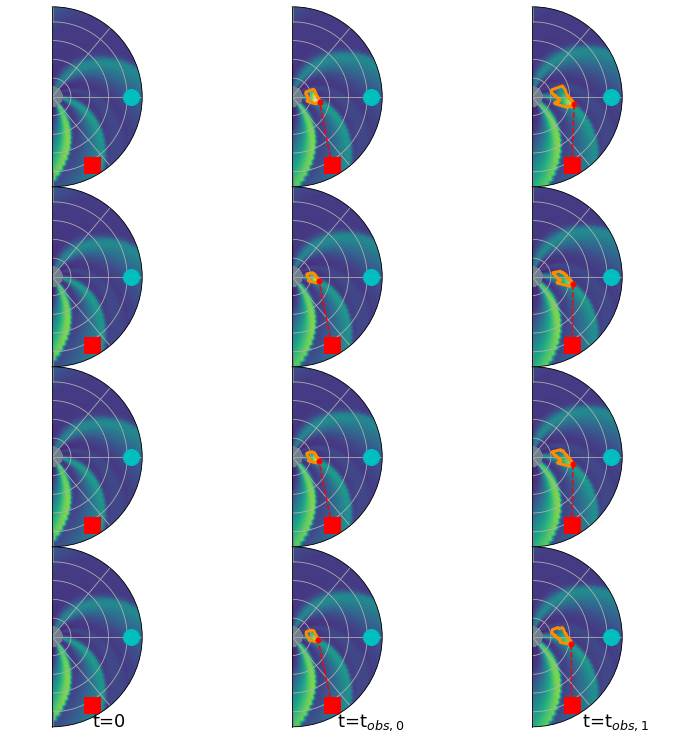

In [18]:
np.random.seed(20110114)

# Set up limits of time window to search for solar wind solutions.
start_time = Time('2008-01-01T00:00:00')
model = setup_huxt(start_time, uniform_wind=False)

n_members = 4
observer_lon = -60*u.deg # approx L5 location

# Initialise Earth directed CME. Coords in HEEQ, so need Earth Lat.
ert = model.get_observer('EARTH')
avg_ert_lat = np.mean(ert.lat.to(u.deg).value)
cme_base = get_base_cme(v=1000, lon=0.0, lat=avg_ert_lat, width=35.0, thickness=1.0)

fig, ax = plt.subplots(4, 3, figsize=(10, 10), subplot_kw={"projection": "polar"} )

for i in range(n_members):
       
    # Perturb the base CME to get a "Truth" CME, and solve
    cme_truth = perturb_cone_cme(cme_base)
    model.solve([cme_truth])
    cme_truth = model.cmes[0]
       
    # Setup an observer at ~L5.
    observer = Observer(model, observer_lon, el_min=4.0, el_max=40.0)
    cme_truth_obs = observer.compute_synthetic_obs(el_spread=0.5, cadence=3, el_min=observer.el_min, el_max=observer.el_max)
      
    for j, ttt in enumerate([0, 20, 40]):
        plot_huxt_with_observer_half_domain_multi(ax[i,j], model.time_out[ttt], model, observer, add_flank=True, add_fov=False)
        
fig.text(0.16, 0, 't=0', fontsize=18)
fig.text(0.5, 0, 't=t$_{obs, 0}$', fontsize=18)
fig.text(0.84, 0, 't=t$_{obs, 1}$', fontsize=18)

fig.subplots_adjust(left=0, right=1.0, bottom=0.0, top=1.0, wspace=0, hspace=0)
fig.savefig('multitest.png')

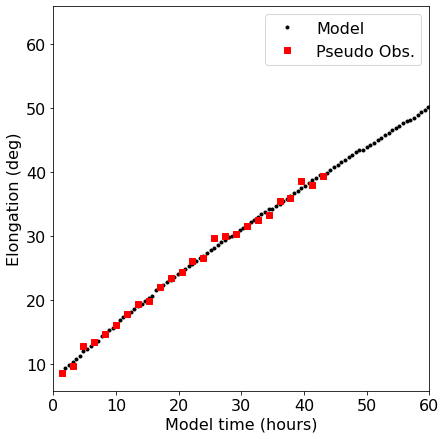

In [51]:
fig, ax = plt.subplots(figsize=(6,6))
time = Time(observer.model_flank['time'], format='jd').datetime - start_time.datetime
time = np.array([t.total_seconds()/3600 for t in time])
ax.plot(time, observer.model_flank['el'], 'k.', label='Model')
time = Time(cme_truth_obs['time'], format='jd').datetime - start_time.datetime
time = np.array([t.total_seconds()/3600 for t in time])
ax.plot(time, cme_truth_obs['el'], 'rs', label='Pseudo Obs.')

ax.set_xlabel('Model time (hours)')
ax.set_xlim(0, 60)
ax.set_ylabel('Elongation (deg)')
ax.legend()
fig.subplots_adjust(left=0.12, bottom=0.1, right=0.99, top=0.99)
fig.savefig('synthetic_elons.png')

In [56]:
def huge_multi_plot(ax, time, model):
    
    id_t = np.argmin(np.abs(model.time_out - time))

    # Get plotting data
    lon_arr, dlon, nlon = H.longitude_grid()
    lon, rad = np.meshgrid(lon_arr.value, model.r.value)
    mymap = mpl.cm.viridis
    v_sub = model.v_grid_amb.value[id_t, :, :].copy()
    # Insert into full array
    if lon_arr.size != model.lon.size:
        v = np.zeros((model.nr, nlon)) * np.NaN
        if model.lon.size != 1:
            for i, lo in enumerate(model.lon):
                id_match = np.argwhere(lon_arr == lo)[0][0]
                v[:, id_match] = v_sub[:, i]
        else:
            print('Warning: Trying to contour single radial solution will fail.')
    else:
        v = v_sub

    # Pad out to fill the full 2pi of contouring
    pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
    lon = np.concatenate((lon, pad), axis=1)
    pad = rad[:, 0].reshape((rad.shape[0], 1))
    rad = np.concatenate((rad, pad), axis=1)
    pad = v[:, 0].reshape((v.shape[0], 1))
    v = np.concatenate((v, pad), axis=1)

    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    levels = np.arange(200, 800 + 10, 10)
    cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')

    ax.set_ylim(0, 240)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.patch.set_facecolor('slategrey')
    return

Files already exist for CR2103
Files already exist for CR2112
Files already exist for CR2113
Files already exist for CR2100
Files already exist for CR2088
Files already exist for CR2119
Files already exist for CR2072
Files already exist for CR2115
Files already exist for CR2066
Files already exist for CR2084
Files already exist for CR2088
Files already exist for CR2101
Files already exist for CR2109
Files already exist for CR2102
Files already exist for CR2113
Files already exist for CR2107
Files already exist for CR2072
Files already exist for CR2115
Files already exist for CR2107
Files already exist for CR2122
Files already exist for CR2091
Files already exist for CR2097
Files already exist for CR2083
Files already exist for CR2090
Files already exist for CR2119
Files already exist for CR2127
Files already exist for CR2118
Files already exist for CR2127
Files already exist for CR2101
Files already exist for CR2073
Files already exist for CR2121
Files already exist for CR2127
Files al

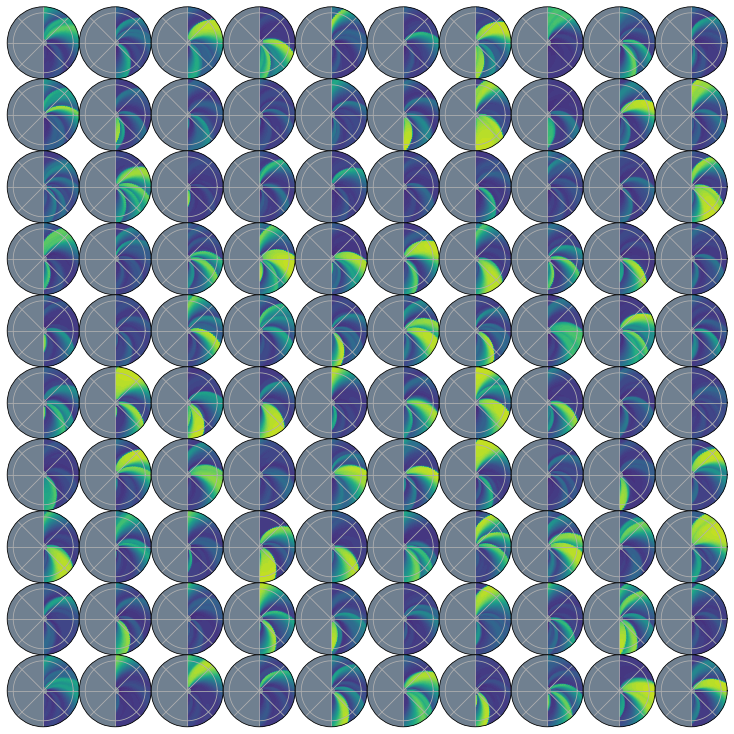

In [61]:
np.random.seed(20110114)

# Set up limits of time window to search for solar wind solutions.
start_time = Time('2008-01-01T00:00:00')
end_time = Time('2013-01-05T00:00:00')

n_truth = 100
n_members = 50
observer_lon = -60*u.deg # approx L5 location

fig, ax = plt.subplots(10, 10, figsize=(10,10), subplot_kw={"projection": "polar"})
axr = ax.ravel()
for i in range(n_truth):
    
    initial_time = np.random.uniform(start_time.jd, end_time.jd, 1)
    initial_time = Time(initial_time, format='jd')
    initial_time = Time(initial_time.isot[0]) # Why do I have to do this?????
    cr_num = np.fix(sn.carrington_rotation_number(initial_time))
    ert = H.Observer('EARTH', initial_time)

    # Set up HUXt for a 5 day simulation with homogenous inner boundary.
    vr_in, br_in = H.Hin.get_MAS_long_profile(cr_num, ert.lat.to(u.deg))
    
    model = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
                   br_boundary=br_in, lon_start=270*u.deg, lon_stop=90*u.deg, simtime=0.5*u.day, dt_scale=4)
    model.solve([])
    
    huge_multi_plot(axr[i], model.time_out[0], model)
    
fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
fig.savefig('huge_multi.png')